Cargando MNIST...
Train: (51000, 784), Val: (9000, 784), Test: (10000, 784)

Entrenando...
Epoch 10/20 - loss: 20.7233 - acc: 0.1000 - val_loss: 20.7284 - val_acc: 0.0998
Epoch 20/20 - loss: 20.7204 - acc: 0.1001 - val_loss: 20.7284 - val_acc: 0.0998

RESULTADO FINAL EN TEST
Test Loss: 20.7233
Test Accuracy: 0.1000 (10.00%)


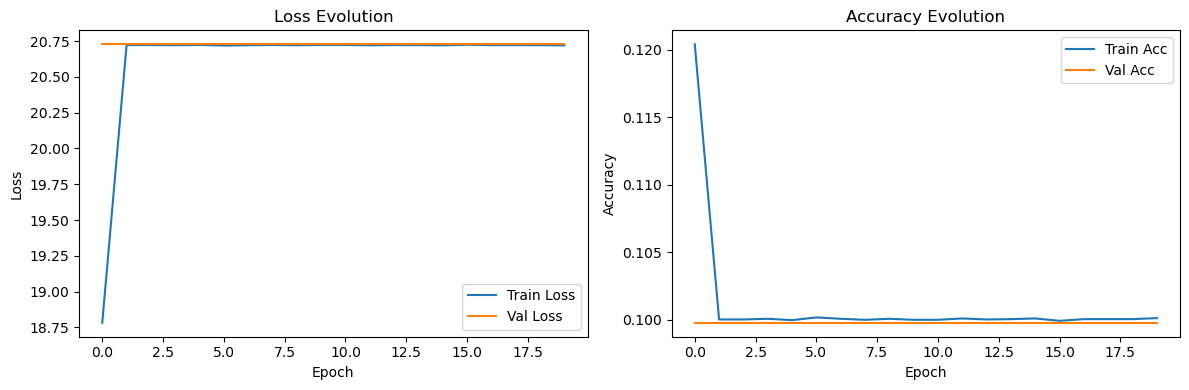

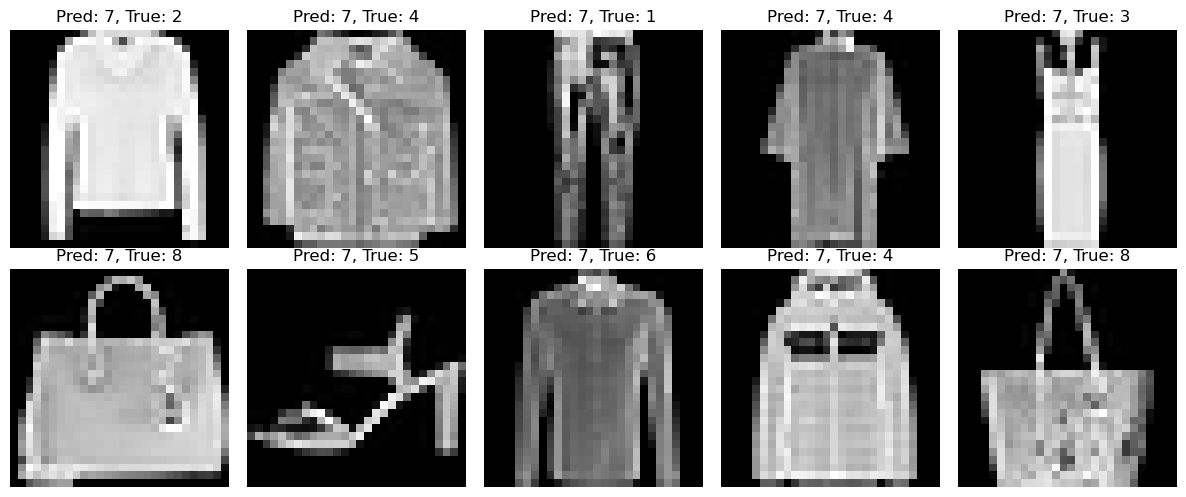

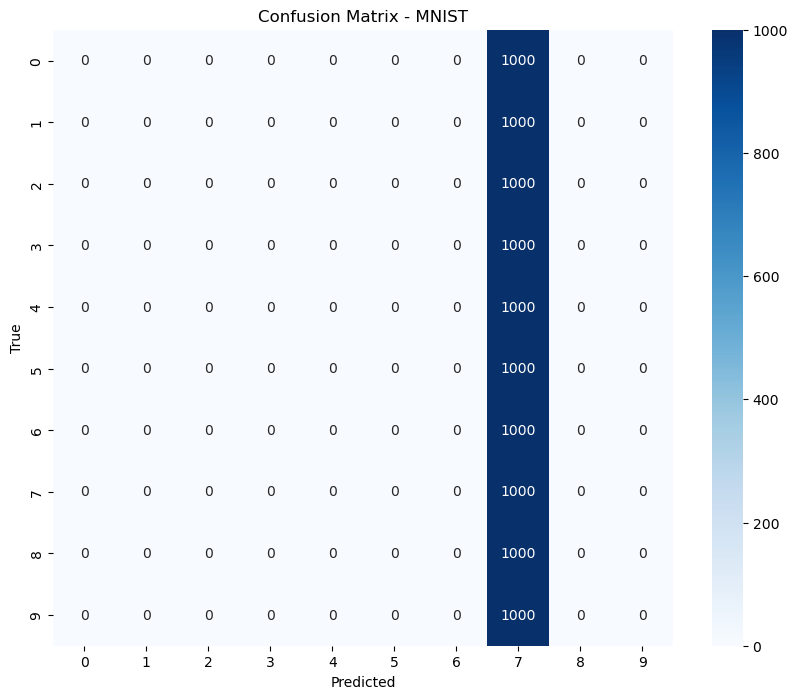

"\n#OPCIONES DE MEJORA POR SI EL ACCURACU <80%\n\n# OPCIÓN A: Red más profunda\narchitecture = [\n    (784, None),\n    (256, 'relu'),\n    (128, 'relu'),\n    (64, 'relu'),\n    (10, 'softmax')\n]\n\n# OPCIÓN B: Más épocas y learning rate menor\noptimizer = Adam(learning_rate=0.0005)\ntrainer.train(..., epochs=50, batch_size=64)\n\n# OPCIÓN C: Mejor inicialización (He para ReLU)\n# Modificar en layers.py el __init__ de Dense:\n\nif weight_init == 'he':\n    self.W = np.random.randn(n_inputs, n_neurons) * np.sqrt(2/n_inputs)\n"

In [ ]:
import sys
sys.path.append('../')

import numpy as np
from src.datasets import load_mnist
from src.neural_network import NeuralNetwork
from src.optimizers import Adam
from src.trainer import Trainer
from src.utils import train_val_test_split, one_hot_encode
import matplotlib.pyplot as plt

# Cargar MNIST
print("Cargando MNIST...")
X_train_full, y_train_full, X_test, y_test = load_mnist()

# Split train/val
X_train, y_train, X_val, y_val, _, _ = train_val_test_split(
    X_train_full, 
    one_hot_encode(y_train_full, 10),
    train_ratio=0.85,
    val_ratio=0.15,
    test_ratio=0.0,
    random_seed=42
)

y_test_oh = one_hot_encode(y_test, 10)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Arquitectura: 784 -> 128 -> 64 -> 10
architecture = [
    (784, None),
    (128, 'relu'),
    (64, 'relu'),
    (10, 'softmax')
]

model = NeuralNetwork(architecture, loss='categorical_crossentropy')
optimizer = Adam(learning_rate=0.001, beta1=0.9, beta2=0.999)
trainer = Trainer(model, optimizer)

# Entrenar
print("\nEntrenando...")

trainer.train(X_train, y_train, X_val, y_val,
              epochs=30,
              batch_size=128,
              verbose=True)

# Evaluar en test
test_loss, test_acc = trainer.evaluate(X_test, y_test_oh)
print(f"\n{'='*50}")
print(f"RESULTADO FINAL EN TEST")
print(f"{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Graficar
trainer.plot_history()

# Mostrar ejemplos de predicciones
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
indices = np.random.choice(len(X_test), 10)

for idx, ax in zip(indices, axes.flat):
    img = X_test[idx].reshape(28, 28)
    pred = np.argmax(model.forward(X_test[idx:idx+1]))
    true = y_test[idx]
    
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Pred: {pred}, True: {true}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_test = model.forward(X_test)
y_pred_labels = np.argmax(y_pred_test, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MNIST')
plt.show()

'''
#OPCIONES DE MEJORA POR SI EL ACCURACU <80%

# OPCIÓN A: Red más profunda
architecture = [
    (784, None),
    (256, 'relu'),
    (128, 'relu'),
    (64, 'relu'),
    (10, 'softmax')
]

# OPCIÓN B: Más épocas y learning rate menor
optimizer = Adam(learning_rate=0.0005)
trainer.train(..., epochs=50, batch_size=64)

# OPCIÓN C: Mejor inicialización (He para ReLU)
# Modificar en layers.py el __init__ de Dense:

if weight_init == 'he':
    self.W = np.random.randn(n_inputs, n_neurons) * np.sqrt(2/n_inputs)
'''